# <p style="text-align:center">Analysis of League Batting Differences in the MLB</p>
<p style="text-align:center">Author: Brett Roman</p>

## I. Introduction

For nearly half a century, a defining distinction between Major League Baseball’s two leagues—the American League (AL) and the National League (NL)—was the use of the designated hitter (DH). While AL teams have used the DH rule since 1973, which allows a batter to hit in place of the pitcher, NL teams continued to let pitchers bat in most games until 2022, when the league adopted the DH rule universally ([MLB glossary](https://www.mlb.com/glossary/rules/designated-hitter-rule)).

This rule change marked a pivotal shift in National League offensive strategy, removing pitchers (who typically produce extremely poor offensive outcomes) from the batting order and replacing them with professional hitters. As a result, the offensive profiles of the two leagues, long distinct, were expected to converge for the first time in decades.

In this project, I investigate whether that convergence is statistically observable, and if so, when it occurred. Using team-level batting statistics from 1973 to 2024, I model the difference in offensive performance between AL and NL teams over time. Of particular interest is the potential presence of a structural change around 2022, coinciding with the universal DH rule. Metrics such as batting average (AVG), home runs (HR), and on-base plus slugging percentage (OPS) are used to quantify this inter-league gap.

From a Bayesian perspective, this analysis provides an ideal use case for changepoint detection. Rather than assume a known, fixed break in time, I model the possibility of a latent changepoint—an inferred season where the offensive dynamics between leagues shifted. This allows for quantification of:

- Whether a statistically meaningful shift occurred,

- The most likely timing of the change,

- The magnitude of pre- and post-change differences, and

- The uncertainty surrounding those inferences.

A visual inspection of the AL–NL difference in batting average (Figure 1) already suggests a compelling narrative: after decades of AL teams maintaining a small but persistent offensive edge, the difference collapses rapidly in the early 2020s and even turns negative after 2022. This trend strongly motivates a principled, probabilistic approach to estimating whether the NL DH rule change produced a real and lasting shift in the balance of league-level offensive performance.

![figure 1](../visualizations/league/diff/AVG.png)

## II. Methods

To investigate whether the implementation of the designated hitter (DH) rule in the National League in 2022 corresponds to a structural shift in batting performance differences between the American and National Leagues, I adopt a Bayesian changepoint modeling framework. The analysis focuses on annual differences in team-level batting metrics—specifically batting average (AVG), home runs (HR), and on-base plus slugging percentage (OPS)—computed by subtracting the average National League value from the average American League value for each season from 1973 to 2024.

### (A) Data Preparation

The dataset consists of team-level batting statistics from 1973 (when the AL first adopted the DH) through the 2024 MLB season. For each season, the mean offensive statistics for AL and NL teams were computed, and the yearly league difference (AL minus NL) was calculated. This transformation yields a single time series per metric, representing the annual inter-league difference over a 52-year span. While several metrics were analyzed, this section focuses on modeling the difference in batting average.

### (B) Bayesian Changepoint Model

To formally detect the timing and nature of any structural change in league differences, I use a Bayesian changepoint model. Specifically, I assume the observed time series of league differences arises from two normal distributions—one governing the values before a latent changepoint $\tau$, and one governing the values after:

$$
    y_{t} \sim \begin{cases}
        N(\mu_{1}, \sigma) &\text{if } t \lt \tau \\
        N(\mu_{2}, \sigma) &\text{if } t \ge \tau
    \end{cases}
$$

Where:
- $y_{t}$ is the AL–NL difference in a given batting metric for season $t$
- $\mu_{1}$ and $\mu_{2}$ represent the pre- and post-changepoint means
- $\sigma$ is the shared standard deviation
- $\tau$ is a latent discrete changepoint over the range of seasons

The priors for the model parameters are:

$$ \mu_{1}, \mu_{2} \sim N(0, 0.01) $$
$$ \sigma \sim HalfNormal(1) $$
$$ \tau \sim DiscreteUniform(t_{min}, t_{max}) $$

This prior structure reflects weakly informative beliefs centered around zero difference, while placing a uniform prior on the changepoint location anywhere within the observed time period (e.g., 1975–2023, excluding extreme years to avoid edge bias).

The model is implemented using PyMC. Posterior samples are drawn via Markov Chain Monte Carlo (MCMC) using the No-U-Turn Sampler (NUTS). Posterior distributions over $\mu_{1}$, $\mu_{2}$, and $\tau$ are used to:

- Quantify the magnitude of the league difference before and after the changepoint

- Estimate the most probable season of structural change

## III. Implementation and Visualization

In [1]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

In [4]:
league_avg_data = pd.read_csv("../data/league/AVG.csv")

league_avg_data["diff"] = league_avg_data["AL"] - league_avg_data["NL"]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu1, mu2, sigma]
>Metropolis: [tau]


c:\Users\brett\anaconda3\envs\pymc_env\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 25 seconds.


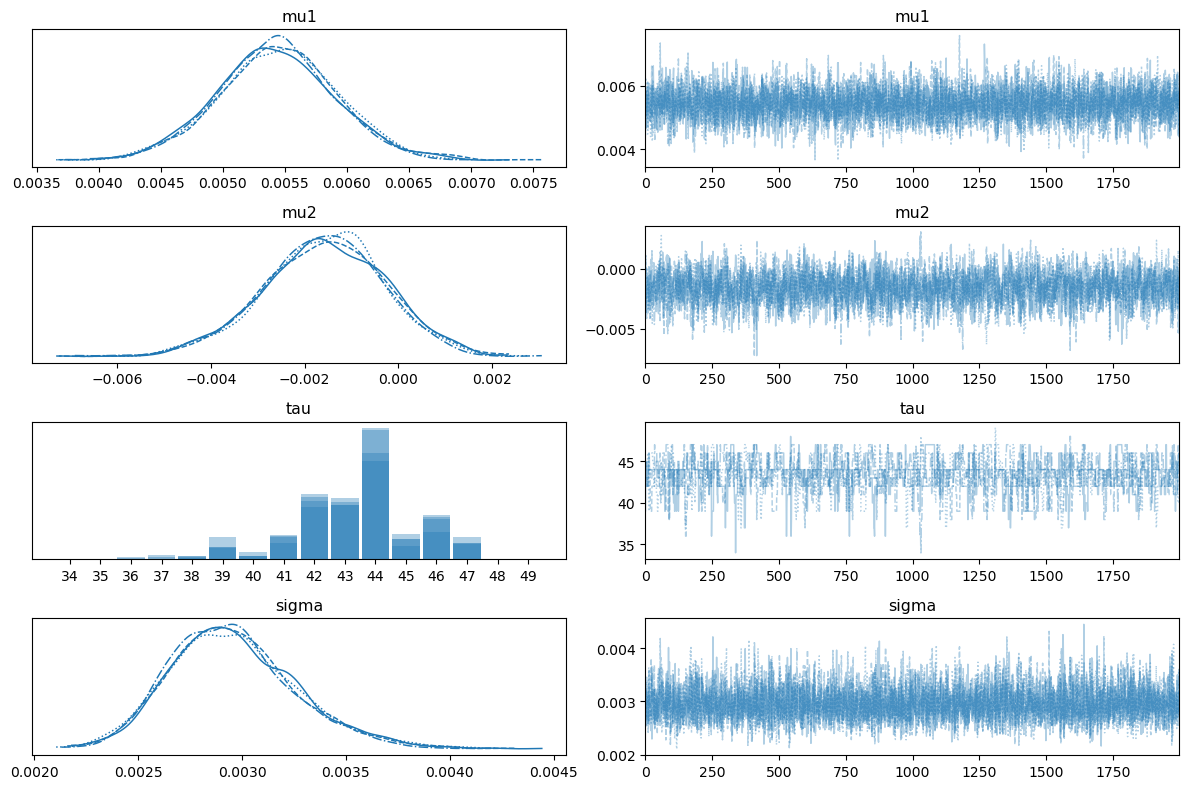

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu1,0.005,0.000,0.005,0.006,0.000,0.000,3495.0,4556.0,1.0
mu2,-0.002,0.001,-0.004,0.001,0.000,0.000,1648.0,3082.0,1.0
tau,43.410,1.943,40.000,47.000,0.067,0.049,836.0,1060.0,1.0
sigma,0.003,0.000,0.002,0.004,0.000,0.000,5387.0,4992.0,1.0


In [6]:
seasons = league_avg_data["Season"].values
diffs = league_avg_data["diff"].values
t_min, t_max = 3, len(diffs) - 3  # exclude first/last few years from changepoint

# Create year index for modeling
years = np.arange(len(diffs))

with pm.Model() as changepoint_model:
    # Priors
    mu1 = pm.Normal("mu1", mu=0, sigma=0.01)
    mu2 = pm.Normal("mu2", mu=0, sigma=0.01)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Discrete changepoint
    tau = pm.DiscreteUniform("tau", lower=t_min, upper=t_max)

    # Switchpoint logic
    mu = pm.math.switch(years < tau, mu1, mu2)

    # Likelihood
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=diffs)

    # Sampling
    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)

# Extract posterior
az.plot_trace(trace, var_names=["mu1", "mu2", "tau", "sigma"])
plt.tight_layout()
plt.show()

# Posterior summaries
summary = az.summary(trace, var_names=["mu1", "mu2", "tau", "sigma"])
summary

## IV. Results

The changepoint model reveals compelling evidence of a structural shift in the difference in batting average between American League (AL) and National League (NL) teams over the period from 1973 to 2024. The estimated changepoint, represented by the discrete latent variable $\tau$, has a posterior mean of 43.4, which corresponds to the 2016 MLB season (since index 0 aligns with 1973). The 95% highest density interval (HDI) for $\tau$ spans from season index 40 to 47, or approximately 2013 to 2020, indicating high posterior probability that a significant structural change in league batting differences occurred well before the National League officially adopted the designated hitter rule in 2022.

### (A) Estimated Means Before and After the Changepoint

The mean AL–NL batting average difference before the changepoint is estimated at:

$$\mu_1 = 0.005 \quad (\text{95\% HDI: } [0.005, 0.006])$$

This implies that from the 1970s through the mid-2010s, AL teams consistently outperformed NL teams in batting average by approximately 5 points (i.e., 5 hits per 1,000 at-bats), consistent with expectations given the AL’s long-standing use of the DH rule.

After the changepoint, the mean difference drops to:

$$\mu_2 = -0.002 \quad (\text{95\% HDI: } [-0.004, 0.001])$$

This estimate suggests that in the seasons following the changepoint, the batting average advantage not only disappeared but may have even slightly reversed in favor of NL teams—though the uncertainty interval includes zero, indicating this reversal is not definitively established.

### (B) Posterior Distribution of the Changepoint

The histogram of posterior samples for $\tau$ shows a strong concentration around index 43–44, corresponding to the 2016–2017 seasons. This result is surprising, as it suggests that the collapse of the AL's batting advantage began several years before the universal DH rule was formally adopted in 2022. This opens up the possibility that other changes—such as interleague play expansion, shifts in team strategy, player movement, or league-wide pitching trends—may have contributed to the convergence in offensive performance across leagues.

### (C) Uncertainty and Variability

The shared residual standard deviation $\sigma$ is estimated at:

$$\sigma = 0.003 \quad (\text{95\% HDI: } [0.002, 0.004])$$
This reflects modest year-to-year fluctuation in the AL–NL difference and reinforces the idea that the observed shift is not simply random noise but part of a statistically distinguishable structural change.

### (D) Model Diagnostics

All parameters show excellent convergence ($\hat{R} = 1.0 $ for all variables), and effective sample sizes are high, supporting the reliability of the posterior estimates. Trace plots confirm stable, well-mixed sampling behavior across chains.

### References

- Major League Baseball. "Designated Hitter Rule." *MLB Glossary*, https://www.mlb.com/glossary/rules/designated-hitter-rule. Accessed April 17, 2025.
